In [37]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [38]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [39]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    #data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    #data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [40]:
import catboost as ctb

In [41]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [42]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [43]:
prep = preprocess(data)

In [44]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [45]:
len(prep[prep.duplicated()])

885

In [46]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [47]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [48]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [49]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [50]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [51]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [52]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6685644	test: 0.6687853	best: 0.6687853 (0)	total: 13.5ms	remaining: 1m 7s
1:	learn: 0.6447196	test: 0.6453401	best: 0.6453401 (1)	total: 36.5ms	remaining: 1m 31s
2:	learn: 0.6230855	test: 0.6239113	best: 0.6239113 (2)	total: 51.2ms	remaining: 1m 25s
3:	learn: 0.6011617	test: 0.6023682	best: 0.6023682 (3)	total: 76.5ms	remaining: 1m 35s
4:	learn: 0.5815877	test: 0.5829641	best: 0.5829641 (4)	total: 85.1ms	remaining: 1m 25s
5:	learn: 0.5622566	test: 0.5639666	best: 0.5639666 (5)	total: 110ms	remaining: 1m 31s
6:	learn: 0.5444324	test: 0.5463698	best: 0.5463698 (6)	total: 124ms	remaining: 1m 28s
7:	learn: 0.5262453	test: 0.5282675	best: 0.5282675 (7)	total: 149ms	remaining: 1m 32s
8:	learn: 0.5108427	test: 0.5130828	best: 0.5130828 (8)	total: 158ms	remaining: 1m 27s
9:	learn: 0.4948895	test: 0.4973197	best: 0.4973197 (9)	total: 181ms	remaining: 1m 30s
10:	learn: 0.4775453	test: 0.4800249	best: 0.4800249 (10)	total: 204ms	remaining: 1m 32s
11:	learn: 0.4632145	test: 0.4657821	

96:	learn: 0.1270477	test: 0.1379685	best: 0.1379685 (96)	total: 1.72s	remaining: 1m 26s
97:	learn: 0.1264509	test: 0.1374355	best: 0.1374355 (97)	total: 1.74s	remaining: 1m 27s
98:	learn: 0.1257207	test: 0.1367949	best: 0.1367949 (98)	total: 1.76s	remaining: 1m 27s
99:	learn: 0.1252450	test: 0.1363206	best: 0.1363206 (99)	total: 1.78s	remaining: 1m 27s
100:	learn: 0.1247832	test: 0.1358850	best: 0.1358850 (100)	total: 1.79s	remaining: 1m 26s
101:	learn: 0.1244523	test: 0.1355612	best: 0.1355612 (101)	total: 1.8s	remaining: 1m 26s
102:	learn: 0.1240092	test: 0.1351713	best: 0.1351713 (102)	total: 1.82s	remaining: 1m 26s
103:	learn: 0.1231018	test: 0.1343654	best: 0.1343654 (103)	total: 1.84s	remaining: 1m 26s
104:	learn: 0.1224765	test: 0.1337507	best: 0.1337507 (104)	total: 1.86s	remaining: 1m 26s
105:	learn: 0.1217750	test: 0.1330704	best: 0.1330704 (105)	total: 1.88s	remaining: 1m 26s
106:	learn: 0.1214057	test: 0.1327249	best: 0.1327249 (106)	total: 1.9s	remaining: 1m 26s
107:	lear

193:	learn: 0.0945407	test: 0.1101435	best: 0.1101435 (193)	total: 3.61s	remaining: 1m 29s
194:	learn: 0.0943852	test: 0.1100220	best: 0.1100220 (194)	total: 3.64s	remaining: 1m 29s
195:	learn: 0.0941669	test: 0.1098238	best: 0.1098238 (195)	total: 3.65s	remaining: 1m 29s
196:	learn: 0.0940268	test: 0.1096859	best: 0.1096859 (196)	total: 3.67s	remaining: 1m 29s
197:	learn: 0.0939149	test: 0.1095956	best: 0.1095956 (197)	total: 3.69s	remaining: 1m 29s
198:	learn: 0.0937688	test: 0.1095244	best: 0.1095244 (198)	total: 3.71s	remaining: 1m 29s
199:	learn: 0.0936596	test: 0.1094095	best: 0.1094095 (199)	total: 3.73s	remaining: 1m 29s
200:	learn: 0.0933827	test: 0.1092630	best: 0.1092630 (200)	total: 3.75s	remaining: 1m 29s
201:	learn: 0.0931887	test: 0.1090948	best: 0.1090948 (201)	total: 3.77s	remaining: 1m 29s
202:	learn: 0.0930342	test: 0.1089301	best: 0.1089301 (202)	total: 3.79s	remaining: 1m 29s
203:	learn: 0.0927106	test: 0.1087171	best: 0.1087171 (203)	total: 3.81s	remaining: 1m 29s

292:	learn: 0.0804814	test: 0.0992600	best: 0.0992600 (292)	total: 5.51s	remaining: 1m 28s
293:	learn: 0.0802629	test: 0.0990471	best: 0.0990471 (293)	total: 5.54s	remaining: 1m 28s
294:	learn: 0.0800917	test: 0.0989526	best: 0.0989526 (294)	total: 5.56s	remaining: 1m 28s
295:	learn: 0.0800181	test: 0.0989121	best: 0.0989121 (295)	total: 5.58s	remaining: 1m 28s
296:	learn: 0.0799312	test: 0.0988199	best: 0.0988199 (296)	total: 5.6s	remaining: 1m 28s
297:	learn: 0.0796799	test: 0.0986266	best: 0.0986266 (297)	total: 5.62s	remaining: 1m 28s
298:	learn: 0.0796262	test: 0.0985914	best: 0.0985914 (298)	total: 5.64s	remaining: 1m 28s
299:	learn: 0.0794219	test: 0.0984417	best: 0.0984417 (299)	total: 5.66s	remaining: 1m 28s
300:	learn: 0.0793216	test: 0.0983739	best: 0.0983739 (300)	total: 5.68s	remaining: 1m 28s
301:	learn: 0.0791872	test: 0.0983029	best: 0.0983029 (301)	total: 5.7s	remaining: 1m 28s
302:	learn: 0.0790906	test: 0.0982582	best: 0.0982582 (302)	total: 5.72s	remaining: 1m 28s
3

383:	learn: 0.0723620	test: 0.0936589	best: 0.0936508 (381)	total: 7.45s	remaining: 1m 29s
384:	learn: 0.0723150	test: 0.0936246	best: 0.0936246 (384)	total: 7.47s	remaining: 1m 29s
385:	learn: 0.0722509	test: 0.0936102	best: 0.0936102 (385)	total: 7.5s	remaining: 1m 29s
386:	learn: 0.0721888	test: 0.0935992	best: 0.0935992 (386)	total: 7.52s	remaining: 1m 29s
387:	learn: 0.0721435	test: 0.0935915	best: 0.0935915 (387)	total: 7.55s	remaining: 1m 29s
388:	learn: 0.0720035	test: 0.0934731	best: 0.0934731 (388)	total: 7.57s	remaining: 1m 29s
389:	learn: 0.0719684	test: 0.0934574	best: 0.0934574 (389)	total: 7.6s	remaining: 1m 29s
390:	learn: 0.0719549	test: 0.0934444	best: 0.0934444 (390)	total: 7.62s	remaining: 1m 29s
391:	learn: 0.0719302	test: 0.0933928	best: 0.0933928 (391)	total: 7.63s	remaining: 1m 29s
392:	learn: 0.0718607	test: 0.0933238	best: 0.0933238 (392)	total: 7.66s	remaining: 1m 29s
393:	learn: 0.0718172	test: 0.0933237	best: 0.0933237 (393)	total: 7.68s	remaining: 1m 29s
3

482:	learn: 0.0663198	test: 0.0899282	best: 0.0899282 (482)	total: 9.54s	remaining: 1m 29s
483:	learn: 0.0662796	test: 0.0899072	best: 0.0899072 (483)	total: 9.56s	remaining: 1m 29s
484:	learn: 0.0662290	test: 0.0898916	best: 0.0898916 (484)	total: 9.58s	remaining: 1m 29s
485:	learn: 0.0661734	test: 0.0898502	best: 0.0898502 (485)	total: 9.6s	remaining: 1m 29s
486:	learn: 0.0661552	test: 0.0898484	best: 0.0898484 (486)	total: 9.62s	remaining: 1m 29s
487:	learn: 0.0661121	test: 0.0898315	best: 0.0898315 (487)	total: 9.64s	remaining: 1m 29s
488:	learn: 0.0660610	test: 0.0897975	best: 0.0897975 (488)	total: 9.67s	remaining: 1m 29s
489:	learn: 0.0658894	test: 0.0896620	best: 0.0896620 (489)	total: 9.69s	remaining: 1m 29s
490:	learn: 0.0658464	test: 0.0896140	best: 0.0896140 (490)	total: 9.71s	remaining: 1m 29s
491:	learn: 0.0658094	test: 0.0895939	best: 0.0895939 (491)	total: 9.74s	remaining: 1m 29s
492:	learn: 0.0657524	test: 0.0895957	best: 0.0895939 (491)	total: 9.77s	remaining: 1m 29s


574:	learn: 0.0614190	test: 0.0868366	best: 0.0868366 (574)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.0613643	test: 0.0867973	best: 0.0867973 (575)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.0613225	test: 0.0867696	best: 0.0867696 (576)	total: 11.5s	remaining: 1m 28s
577:	learn: 0.0612523	test: 0.0867445	best: 0.0867445 (577)	total: 11.5s	remaining: 1m 28s
578:	learn: 0.0611969	test: 0.0867156	best: 0.0867156 (578)	total: 11.5s	remaining: 1m 28s
579:	learn: 0.0611779	test: 0.0866944	best: 0.0866944 (579)	total: 11.6s	remaining: 1m 28s
580:	learn: 0.0610745	test: 0.0866293	best: 0.0866293 (580)	total: 11.6s	remaining: 1m 28s
581:	learn: 0.0610512	test: 0.0866215	best: 0.0866215 (581)	total: 11.6s	remaining: 1m 28s
582:	learn: 0.0609968	test: 0.0865693	best: 0.0865693 (582)	total: 11.6s	remaining: 1m 28s
583:	learn: 0.0609938	test: 0.0865635	best: 0.0865635 (583)	total: 11.6s	remaining: 1m 27s
584:	learn: 0.0609849	test: 0.0865599	best: 0.0865599 (584)	total: 11.6s	remaining: 1m 27s

673:	learn: 0.0569095	test: 0.0841824	best: 0.0841824 (673)	total: 13.3s	remaining: 1m 25s
674:	learn: 0.0569024	test: 0.0841774	best: 0.0841774 (674)	total: 13.4s	remaining: 1m 25s
675:	learn: 0.0568678	test: 0.0841517	best: 0.0841517 (675)	total: 13.4s	remaining: 1m 25s
676:	learn: 0.0567831	test: 0.0841116	best: 0.0841116 (676)	total: 13.4s	remaining: 1m 25s
677:	learn: 0.0567348	test: 0.0840817	best: 0.0840817 (677)	total: 13.4s	remaining: 1m 25s
678:	learn: 0.0566715	test: 0.0840670	best: 0.0840670 (678)	total: 13.4s	remaining: 1m 25s
679:	learn: 0.0566319	test: 0.0840631	best: 0.0840631 (679)	total: 13.5s	remaining: 1m 25s
680:	learn: 0.0566081	test: 0.0840558	best: 0.0840558 (680)	total: 13.5s	remaining: 1m 25s
681:	learn: 0.0565955	test: 0.0840521	best: 0.0840521 (681)	total: 13.5s	remaining: 1m 25s
682:	learn: 0.0564640	test: 0.0840164	best: 0.0840164 (682)	total: 13.5s	remaining: 1m 25s
683:	learn: 0.0564072	test: 0.0839689	best: 0.0839689 (683)	total: 13.5s	remaining: 1m 25s

766:	learn: 0.0530799	test: 0.0821015	best: 0.0821015 (766)	total: 15.2s	remaining: 1m 23s
767:	learn: 0.0530646	test: 0.0821096	best: 0.0821015 (766)	total: 15.2s	remaining: 1m 23s
768:	learn: 0.0529433	test: 0.0820185	best: 0.0820185 (768)	total: 15.3s	remaining: 1m 23s
769:	learn: 0.0529432	test: 0.0820184	best: 0.0820184 (769)	total: 15.3s	remaining: 1m 23s
770:	learn: 0.0529306	test: 0.0820139	best: 0.0820139 (770)	total: 15.3s	remaining: 1m 23s
771:	learn: 0.0528728	test: 0.0819642	best: 0.0819642 (771)	total: 15.3s	remaining: 1m 23s
772:	learn: 0.0528114	test: 0.0819449	best: 0.0819449 (772)	total: 15.3s	remaining: 1m 23s
773:	learn: 0.0527686	test: 0.0819346	best: 0.0819346 (773)	total: 15.4s	remaining: 1m 23s
774:	learn: 0.0527304	test: 0.0818867	best: 0.0818867 (774)	total: 15.4s	remaining: 1m 23s
775:	learn: 0.0526777	test: 0.0818475	best: 0.0818475 (775)	total: 15.4s	remaining: 1m 23s
776:	learn: 0.0526691	test: 0.0818416	best: 0.0818416 (776)	total: 15.4s	remaining: 1m 23s

861:	learn: 0.0494183	test: 0.0801574	best: 0.0801574 (861)	total: 17.4s	remaining: 1m 23s
862:	learn: 0.0493721	test: 0.0801420	best: 0.0801420 (862)	total: 17.4s	remaining: 1m 23s
863:	learn: 0.0492987	test: 0.0800798	best: 0.0800798 (863)	total: 17.4s	remaining: 1m 23s
864:	learn: 0.0492259	test: 0.0800407	best: 0.0800407 (864)	total: 17.4s	remaining: 1m 23s
865:	learn: 0.0491974	test: 0.0800390	best: 0.0800390 (865)	total: 17.4s	remaining: 1m 23s
866:	learn: 0.0491433	test: 0.0800060	best: 0.0800060 (866)	total: 17.5s	remaining: 1m 23s
867:	learn: 0.0491366	test: 0.0800052	best: 0.0800052 (867)	total: 17.5s	remaining: 1m 23s
868:	learn: 0.0491288	test: 0.0800006	best: 0.0800006 (868)	total: 17.5s	remaining: 1m 23s
869:	learn: 0.0490956	test: 0.0799781	best: 0.0799781 (869)	total: 17.5s	remaining: 1m 23s
870:	learn: 0.0489975	test: 0.0799224	best: 0.0799224 (870)	total: 17.5s	remaining: 1m 23s
871:	learn: 0.0489840	test: 0.0799224	best: 0.0799224 (870)	total: 17.6s	remaining: 1m 23s

960:	learn: 0.0457755	test: 0.0783483	best: 0.0783483 (960)	total: 19.3s	remaining: 1m 21s
961:	learn: 0.0457485	test: 0.0783508	best: 0.0783483 (960)	total: 19.3s	remaining: 1m 21s
962:	learn: 0.0457360	test: 0.0783577	best: 0.0783483 (960)	total: 19.3s	remaining: 1m 21s
963:	learn: 0.0457338	test: 0.0783588	best: 0.0783483 (960)	total: 19.3s	remaining: 1m 20s
964:	learn: 0.0456966	test: 0.0783691	best: 0.0783483 (960)	total: 19.4s	remaining: 1m 20s
965:	learn: 0.0456373	test: 0.0783407	best: 0.0783407 (965)	total: 19.4s	remaining: 1m 20s
966:	learn: 0.0455903	test: 0.0783494	best: 0.0783407 (965)	total: 19.4s	remaining: 1m 20s
967:	learn: 0.0455552	test: 0.0783278	best: 0.0783278 (967)	total: 19.4s	remaining: 1m 20s
968:	learn: 0.0455437	test: 0.0783228	best: 0.0783228 (968)	total: 19.4s	remaining: 1m 20s
969:	learn: 0.0454936	test: 0.0782645	best: 0.0782645 (969)	total: 19.5s	remaining: 1m 20s
970:	learn: 0.0454908	test: 0.0782634	best: 0.0782634 (970)	total: 19.5s	remaining: 1m 20s

1058:	learn: 0.0429027	test: 0.0769921	best: 0.0769921 (1058)	total: 21.2s	remaining: 1m 18s
1059:	learn: 0.0428928	test: 0.0769837	best: 0.0769837 (1059)	total: 21.2s	remaining: 1m 18s
1060:	learn: 0.0428815	test: 0.0769817	best: 0.0769817 (1060)	total: 21.2s	remaining: 1m 18s
1061:	learn: 0.0428698	test: 0.0769685	best: 0.0769685 (1061)	total: 21.2s	remaining: 1m 18s
1062:	learn: 0.0428676	test: 0.0769687	best: 0.0769685 (1061)	total: 21.2s	remaining: 1m 18s
1063:	learn: 0.0428516	test: 0.0769572	best: 0.0769572 (1063)	total: 21.3s	remaining: 1m 18s
1064:	learn: 0.0427990	test: 0.0769462	best: 0.0769462 (1064)	total: 21.3s	remaining: 1m 18s
1065:	learn: 0.0427610	test: 0.0768878	best: 0.0768878 (1065)	total: 21.3s	remaining: 1m 18s
1066:	learn: 0.0427347	test: 0.0768814	best: 0.0768814 (1066)	total: 21.3s	remaining: 1m 18s
1067:	learn: 0.0427060	test: 0.0768669	best: 0.0768669 (1067)	total: 21.3s	remaining: 1m 18s
1068:	learn: 0.0426992	test: 0.0768651	best: 0.0768651 (1068)	total: 2

1156:	learn: 0.0409331	test: 0.0761158	best: 0.0761158 (1156)	total: 23.1s	remaining: 1m 16s
1157:	learn: 0.0409078	test: 0.0760976	best: 0.0760976 (1157)	total: 23.1s	remaining: 1m 16s
1158:	learn: 0.0409035	test: 0.0761000	best: 0.0760976 (1157)	total: 23.1s	remaining: 1m 16s
1159:	learn: 0.0408994	test: 0.0761084	best: 0.0760976 (1157)	total: 23.1s	remaining: 1m 16s
1160:	learn: 0.0408662	test: 0.0760735	best: 0.0760735 (1160)	total: 23.2s	remaining: 1m 16s
1161:	learn: 0.0408253	test: 0.0760685	best: 0.0760685 (1161)	total: 23.2s	remaining: 1m 16s
1162:	learn: 0.0408115	test: 0.0760578	best: 0.0760578 (1162)	total: 23.2s	remaining: 1m 16s
1163:	learn: 0.0408034	test: 0.0760574	best: 0.0760574 (1163)	total: 23.2s	remaining: 1m 16s
1164:	learn: 0.0407936	test: 0.0760624	best: 0.0760574 (1163)	total: 23.2s	remaining: 1m 16s
1165:	learn: 0.0407473	test: 0.0760185	best: 0.0760185 (1165)	total: 23.3s	remaining: 1m 16s
1166:	learn: 0.0407171	test: 0.0759874	best: 0.0759874 (1166)	total: 2

1245:	learn: 0.0390091	test: 0.0752492	best: 0.0752492 (1245)	total: 25.2s	remaining: 1m 16s
1246:	learn: 0.0389460	test: 0.0751946	best: 0.0751946 (1246)	total: 25.3s	remaining: 1m 16s
1247:	learn: 0.0389213	test: 0.0751779	best: 0.0751779 (1247)	total: 25.3s	remaining: 1m 16s
1248:	learn: 0.0388985	test: 0.0751682	best: 0.0751682 (1248)	total: 25.3s	remaining: 1m 16s
1249:	learn: 0.0388875	test: 0.0751583	best: 0.0751583 (1249)	total: 25.3s	remaining: 1m 15s
1250:	learn: 0.0388693	test: 0.0751631	best: 0.0751583 (1249)	total: 25.4s	remaining: 1m 16s
1251:	learn: 0.0388586	test: 0.0751536	best: 0.0751536 (1251)	total: 25.4s	remaining: 1m 15s
1252:	learn: 0.0387982	test: 0.0751036	best: 0.0751036 (1252)	total: 25.4s	remaining: 1m 15s
1253:	learn: 0.0387901	test: 0.0750981	best: 0.0750981 (1253)	total: 25.4s	remaining: 1m 16s
1254:	learn: 0.0387764	test: 0.0750881	best: 0.0750881 (1254)	total: 25.5s	remaining: 1m 16s
1255:	learn: 0.0387684	test: 0.0750888	best: 0.0750881 (1254)	total: 2

1338:	learn: 0.0369581	test: 0.0741305	best: 0.0741305 (1338)	total: 27.2s	remaining: 1m 14s
1339:	learn: 0.0369223	test: 0.0741318	best: 0.0741305 (1338)	total: 27.2s	remaining: 1m 14s
1340:	learn: 0.0369155	test: 0.0741337	best: 0.0741305 (1338)	total: 27.2s	remaining: 1m 14s
1341:	learn: 0.0369042	test: 0.0741244	best: 0.0741244 (1341)	total: 27.2s	remaining: 1m 14s
1342:	learn: 0.0369000	test: 0.0741215	best: 0.0741215 (1342)	total: 27.3s	remaining: 1m 14s
1343:	learn: 0.0368893	test: 0.0741214	best: 0.0741214 (1343)	total: 27.3s	remaining: 1m 14s
1344:	learn: 0.0368657	test: 0.0741155	best: 0.0741155 (1344)	total: 27.3s	remaining: 1m 14s
1345:	learn: 0.0368500	test: 0.0741193	best: 0.0741155 (1344)	total: 27.3s	remaining: 1m 14s
1346:	learn: 0.0368386	test: 0.0741242	best: 0.0741155 (1344)	total: 27.3s	remaining: 1m 14s
1347:	learn: 0.0368116	test: 0.0741192	best: 0.0741155 (1344)	total: 27.3s	remaining: 1m 14s
1348:	learn: 0.0367970	test: 0.0741229	best: 0.0741155 (1344)	total: 2

1434:	learn: 0.0351444	test: 0.0733565	best: 0.0733565 (1434)	total: 29.1s	remaining: 1m 12s
1435:	learn: 0.0351293	test: 0.0733604	best: 0.0733565 (1434)	total: 29.1s	remaining: 1m 12s
1436:	learn: 0.0351110	test: 0.0733650	best: 0.0733565 (1434)	total: 29.1s	remaining: 1m 12s
1437:	learn: 0.0350854	test: 0.0733675	best: 0.0733565 (1434)	total: 29.1s	remaining: 1m 12s
1438:	learn: 0.0350501	test: 0.0733464	best: 0.0733464 (1438)	total: 29.2s	remaining: 1m 12s
1439:	learn: 0.0350034	test: 0.0732903	best: 0.0732903 (1439)	total: 29.2s	remaining: 1m 12s
1440:	learn: 0.0350000	test: 0.0732921	best: 0.0732903 (1439)	total: 29.2s	remaining: 1m 12s
1441:	learn: 0.0349915	test: 0.0732808	best: 0.0732808 (1441)	total: 29.2s	remaining: 1m 12s
1442:	learn: 0.0349857	test: 0.0732783	best: 0.0732783 (1442)	total: 29.2s	remaining: 1m 12s
1443:	learn: 0.0349775	test: 0.0732782	best: 0.0732782 (1443)	total: 29.2s	remaining: 1m 12s
1444:	learn: 0.0349611	test: 0.0732722	best: 0.0732722 (1444)	total: 2

1532:	learn: 0.0334254	test: 0.0727204	best: 0.0727204 (1532)	total: 31s	remaining: 1m 10s
1533:	learn: 0.0334130	test: 0.0727096	best: 0.0727096 (1533)	total: 31s	remaining: 1m 10s
1534:	learn: 0.0334031	test: 0.0727124	best: 0.0727096 (1533)	total: 31s	remaining: 1m 10s
1535:	learn: 0.0333882	test: 0.0727041	best: 0.0727041 (1535)	total: 31.1s	remaining: 1m 10s
1536:	learn: 0.0333775	test: 0.0727000	best: 0.0727000 (1536)	total: 31.1s	remaining: 1m 10s
1537:	learn: 0.0333702	test: 0.0727042	best: 0.0727000 (1536)	total: 31.1s	remaining: 1m 9s
1538:	learn: 0.0333244	test: 0.0726658	best: 0.0726658 (1538)	total: 31.1s	remaining: 1m 9s
1539:	learn: 0.0333036	test: 0.0726480	best: 0.0726480 (1539)	total: 31.1s	remaining: 1m 9s
1540:	learn: 0.0333024	test: 0.0726466	best: 0.0726466 (1540)	total: 31.2s	remaining: 1m 9s
1541:	learn: 0.0332885	test: 0.0726378	best: 0.0726378 (1541)	total: 31.2s	remaining: 1m 9s
1542:	learn: 0.0332791	test: 0.0726317	best: 0.0726317 (1542)	total: 31.2s	remain

1627:	learn: 0.0318342	test: 0.0719645	best: 0.0719645 (1627)	total: 33.1s	remaining: 1m 8s
1628:	learn: 0.0317901	test: 0.0719408	best: 0.0719408 (1628)	total: 33.2s	remaining: 1m 8s
1629:	learn: 0.0317852	test: 0.0719328	best: 0.0719328 (1629)	total: 33.2s	remaining: 1m 8s
1630:	learn: 0.0317757	test: 0.0719246	best: 0.0719246 (1630)	total: 33.2s	remaining: 1m 8s
1631:	learn: 0.0317161	test: 0.0719189	best: 0.0719189 (1631)	total: 33.2s	remaining: 1m 8s
1632:	learn: 0.0317016	test: 0.0719177	best: 0.0719177 (1632)	total: 33.3s	remaining: 1m 8s
1633:	learn: 0.0316975	test: 0.0719157	best: 0.0719157 (1633)	total: 33.3s	remaining: 1m 8s
1634:	learn: 0.0316907	test: 0.0719194	best: 0.0719157 (1633)	total: 33.3s	remaining: 1m 8s
1635:	learn: 0.0316759	test: 0.0719255	best: 0.0719157 (1633)	total: 33.3s	remaining: 1m 8s
1636:	learn: 0.0316613	test: 0.0719162	best: 0.0719157 (1633)	total: 33.3s	remaining: 1m 8s
1637:	learn: 0.0316528	test: 0.0719044	best: 0.0719044 (1637)	total: 33.4s	remai

1723:	learn: 0.0302958	test: 0.0713980	best: 0.0713980 (1723)	total: 35.2s	remaining: 1m 6s
1724:	learn: 0.0302908	test: 0.0713928	best: 0.0713928 (1724)	total: 35.2s	remaining: 1m 6s
1725:	learn: 0.0302875	test: 0.0713915	best: 0.0713915 (1725)	total: 35.3s	remaining: 1m 6s
1726:	learn: 0.0302851	test: 0.0713914	best: 0.0713914 (1726)	total: 35.3s	remaining: 1m 6s
1727:	learn: 0.0302335	test: 0.0713765	best: 0.0713765 (1727)	total: 35.3s	remaining: 1m 6s
1728:	learn: 0.0302275	test: 0.0713771	best: 0.0713765 (1727)	total: 35.3s	remaining: 1m 6s
1729:	learn: 0.0302229	test: 0.0713752	best: 0.0713752 (1729)	total: 35.3s	remaining: 1m 6s
1730:	learn: 0.0302191	test: 0.0713760	best: 0.0713752 (1729)	total: 35.4s	remaining: 1m 6s
1731:	learn: 0.0302025	test: 0.0713751	best: 0.0713751 (1731)	total: 35.4s	remaining: 1m 6s
1732:	learn: 0.0302011	test: 0.0713753	best: 0.0713751 (1731)	total: 35.4s	remaining: 1m 6s
1733:	learn: 0.0301908	test: 0.0713680	best: 0.0713680 (1733)	total: 35.4s	remai

1817:	learn: 0.0289763	test: 0.0710267	best: 0.0710267 (1817)	total: 37.1s	remaining: 1m 4s
1818:	learn: 0.0289678	test: 0.0710305	best: 0.0710267 (1817)	total: 37.1s	remaining: 1m 4s
1819:	learn: 0.0289626	test: 0.0710249	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1820:	learn: 0.0289461	test: 0.0710418	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1821:	learn: 0.0289421	test: 0.0710426	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1822:	learn: 0.0289282	test: 0.0710383	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1823:	learn: 0.0289138	test: 0.0710368	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1824:	learn: 0.0288935	test: 0.0710328	best: 0.0710249 (1819)	total: 37.2s	remaining: 1m 4s
1825:	learn: 0.0288760	test: 0.0710156	best: 0.0710156 (1825)	total: 37.3s	remaining: 1m 4s
1826:	learn: 0.0288596	test: 0.0710266	best: 0.0710156 (1825)	total: 37.3s	remaining: 1m 4s
1827:	learn: 0.0288560	test: 0.0710277	best: 0.0710156 (1825)	total: 37.3s	remai

1913:	learn: 0.0277010	test: 0.0707787	best: 0.0707787 (1913)	total: 39s	remaining: 1m 2s
1914:	learn: 0.0276956	test: 0.0707758	best: 0.0707758 (1914)	total: 39s	remaining: 1m 2s
1915:	learn: 0.0276625	test: 0.0707494	best: 0.0707494 (1915)	total: 39.1s	remaining: 1m 2s
1916:	learn: 0.0276625	test: 0.0707494	best: 0.0707494 (1916)	total: 39.1s	remaining: 1m 2s
1917:	learn: 0.0276463	test: 0.0707503	best: 0.0707494 (1916)	total: 39.1s	remaining: 1m 2s
1918:	learn: 0.0276375	test: 0.0707504	best: 0.0707494 (1916)	total: 39.1s	remaining: 1m 2s
1919:	learn: 0.0276286	test: 0.0707502	best: 0.0707494 (1916)	total: 39.1s	remaining: 1m 2s
1920:	learn: 0.0276198	test: 0.0707486	best: 0.0707486 (1920)	total: 39.2s	remaining: 1m 2s
1921:	learn: 0.0276198	test: 0.0707485	best: 0.0707485 (1921)	total: 39.2s	remaining: 1m 2s
1922:	learn: 0.0275946	test: 0.0707307	best: 0.0707307 (1922)	total: 39.2s	remaining: 1m 2s
1923:	learn: 0.0275911	test: 0.0707278	best: 0.0707278 (1923)	total: 39.2s	remaining

2011:	learn: 0.0264193	test: 0.0702136	best: 0.0702101 (2007)	total: 41.1s	remaining: 1m 1s
2012:	learn: 0.0264049	test: 0.0702067	best: 0.0702067 (2012)	total: 41.1s	remaining: 1m 1s
2013:	learn: 0.0263969	test: 0.0702049	best: 0.0702049 (2013)	total: 41.2s	remaining: 1m 1s
2014:	learn: 0.0263913	test: 0.0702097	best: 0.0702049 (2013)	total: 41.2s	remaining: 1m 1s
2015:	learn: 0.0263743	test: 0.0702066	best: 0.0702049 (2013)	total: 41.2s	remaining: 1m
2016:	learn: 0.0263653	test: 0.0702065	best: 0.0702049 (2013)	total: 41.2s	remaining: 1m
2017:	learn: 0.0263599	test: 0.0702031	best: 0.0702031 (2017)	total: 41.3s	remaining: 1m
2018:	learn: 0.0263552	test: 0.0701994	best: 0.0701994 (2018)	total: 41.3s	remaining: 1m
2019:	learn: 0.0263443	test: 0.0701894	best: 0.0701894 (2019)	total: 41.3s	remaining: 1m
2020:	learn: 0.0263277	test: 0.0701864	best: 0.0701864 (2020)	total: 41.3s	remaining: 1m
2021:	learn: 0.0263236	test: 0.0701910	best: 0.0701864 (2020)	total: 41.4s	remaining: 1m
2022:	lea

2106:	learn: 0.0251967	test: 0.0700282	best: 0.0700137 (2100)	total: 43.3s	remaining: 59.4s
2107:	learn: 0.0251816	test: 0.0700256	best: 0.0700137 (2100)	total: 43.3s	remaining: 59.4s
2108:	learn: 0.0251593	test: 0.0700313	best: 0.0700137 (2100)	total: 43.3s	remaining: 59.4s
2109:	learn: 0.0251464	test: 0.0700297	best: 0.0700137 (2100)	total: 43.3s	remaining: 59.3s
2110:	learn: 0.0251411	test: 0.0700262	best: 0.0700137 (2100)	total: 43.3s	remaining: 59.3s
2111:	learn: 0.0251162	test: 0.0700309	best: 0.0700137 (2100)	total: 43.4s	remaining: 59.3s
2112:	learn: 0.0251161	test: 0.0700309	best: 0.0700137 (2100)	total: 43.4s	remaining: 59.3s
2113:	learn: 0.0251006	test: 0.0700220	best: 0.0700137 (2100)	total: 43.4s	remaining: 59.3s
2114:	learn: 0.0250980	test: 0.0700185	best: 0.0700137 (2100)	total: 43.4s	remaining: 59.2s
2115:	learn: 0.0250916	test: 0.0700201	best: 0.0700137 (2100)	total: 43.4s	remaining: 59.2s
2116:	learn: 0.0250726	test: 0.0700128	best: 0.0700128 (2116)	total: 43.5s	remai

2203:	learn: 0.0242340	test: 0.0697502	best: 0.0697350 (2201)	total: 45.2s	remaining: 57.3s
2204:	learn: 0.0242279	test: 0.0697488	best: 0.0697350 (2201)	total: 45.2s	remaining: 57.3s
2205:	learn: 0.0242241	test: 0.0697518	best: 0.0697350 (2201)	total: 45.2s	remaining: 57.3s
2206:	learn: 0.0242176	test: 0.0697511	best: 0.0697350 (2201)	total: 45.2s	remaining: 57.2s
2207:	learn: 0.0242132	test: 0.0697570	best: 0.0697350 (2201)	total: 45.2s	remaining: 57.2s
2208:	learn: 0.0242073	test: 0.0697551	best: 0.0697350 (2201)	total: 45.3s	remaining: 57.2s
2209:	learn: 0.0241995	test: 0.0697514	best: 0.0697350 (2201)	total: 45.3s	remaining: 57.2s
2210:	learn: 0.0241978	test: 0.0697534	best: 0.0697350 (2201)	total: 45.3s	remaining: 57.1s
2211:	learn: 0.0241807	test: 0.0697455	best: 0.0697350 (2201)	total: 45.3s	remaining: 57.1s
2212:	learn: 0.0241338	test: 0.0697150	best: 0.0697150 (2212)	total: 45.3s	remaining: 57.1s
2213:	learn: 0.0241172	test: 0.0696881	best: 0.0696881 (2213)	total: 45.4s	remai

2302:	learn: 0.0232175	test: 0.0694859	best: 0.0694859 (2302)	total: 47.1s	remaining: 55.2s
2303:	learn: 0.0232018	test: 0.0694952	best: 0.0694859 (2302)	total: 47.1s	remaining: 55.1s
2304:	learn: 0.0232002	test: 0.0694978	best: 0.0694859 (2302)	total: 47.1s	remaining: 55.1s
2305:	learn: 0.0231935	test: 0.0695020	best: 0.0694859 (2302)	total: 47.2s	remaining: 55.1s
2306:	learn: 0.0231885	test: 0.0695052	best: 0.0694859 (2302)	total: 47.2s	remaining: 55.1s
2307:	learn: 0.0231763	test: 0.0694996	best: 0.0694859 (2302)	total: 47.2s	remaining: 55s
2308:	learn: 0.0231652	test: 0.0694970	best: 0.0694859 (2302)	total: 47.2s	remaining: 55s
2309:	learn: 0.0231548	test: 0.0694945	best: 0.0694859 (2302)	total: 47.2s	remaining: 55s
2310:	learn: 0.0231515	test: 0.0694949	best: 0.0694859 (2302)	total: 47.3s	remaining: 55s
2311:	learn: 0.0231446	test: 0.0694823	best: 0.0694823 (2311)	total: 47.3s	remaining: 55s
2312:	learn: 0.0231384	test: 0.0694826	best: 0.0694823 (2311)	total: 47.3s	remaining: 54.9

2395:	learn: 0.0223905	test: 0.0692529	best: 0.0692490 (2387)	total: 49s	remaining: 53.2s
2396:	learn: 0.0223803	test: 0.0692506	best: 0.0692490 (2387)	total: 49s	remaining: 53.2s
2397:	learn: 0.0223720	test: 0.0692524	best: 0.0692490 (2387)	total: 49s	remaining: 53.2s
2398:	learn: 0.0223646	test: 0.0692493	best: 0.0692490 (2387)	total: 49.1s	remaining: 53.2s
2399:	learn: 0.0223393	test: 0.0692568	best: 0.0692490 (2387)	total: 49.1s	remaining: 53.2s
2400:	learn: 0.0223375	test: 0.0692582	best: 0.0692490 (2387)	total: 49.1s	remaining: 53.2s
2401:	learn: 0.0223248	test: 0.0692532	best: 0.0692490 (2387)	total: 49.1s	remaining: 53.1s
2402:	learn: 0.0223084	test: 0.0692453	best: 0.0692453 (2402)	total: 49.2s	remaining: 53.1s
2403:	learn: 0.0223084	test: 0.0692453	best: 0.0692453 (2403)	total: 49.2s	remaining: 53.1s
2404:	learn: 0.0223026	test: 0.0692361	best: 0.0692361 (2404)	total: 49.2s	remaining: 53.1s
2405:	learn: 0.0222897	test: 0.0692397	best: 0.0692361 (2404)	total: 49.2s	remaining: 

2493:	learn: 0.0215898	test: 0.0690979	best: 0.0690876 (2491)	total: 51.3s	remaining: 51.6s
2494:	learn: 0.0215887	test: 0.0690991	best: 0.0690876 (2491)	total: 51.3s	remaining: 51.5s
2495:	learn: 0.0215654	test: 0.0690830	best: 0.0690830 (2495)	total: 51.4s	remaining: 51.5s
2496:	learn: 0.0215621	test: 0.0690850	best: 0.0690830 (2495)	total: 51.4s	remaining: 51.5s
2497:	learn: 0.0215449	test: 0.0690767	best: 0.0690767 (2497)	total: 51.4s	remaining: 51.5s
2498:	learn: 0.0215392	test: 0.0690753	best: 0.0690753 (2498)	total: 51.4s	remaining: 51.5s
2499:	learn: 0.0215319	test: 0.0690755	best: 0.0690753 (2498)	total: 51.4s	remaining: 51.4s
2500:	learn: 0.0215298	test: 0.0690743	best: 0.0690743 (2500)	total: 51.5s	remaining: 51.4s
2501:	learn: 0.0215194	test: 0.0690650	best: 0.0690650 (2501)	total: 51.5s	remaining: 51.4s
2502:	learn: 0.0215001	test: 0.0690654	best: 0.0690650 (2501)	total: 51.5s	remaining: 51.4s
2503:	learn: 0.0214954	test: 0.0690555	best: 0.0690555 (2503)	total: 51.5s	remai

2592:	learn: 0.0208032	test: 0.0688142	best: 0.0688082 (2591)	total: 53.2s	remaining: 49.4s
2593:	learn: 0.0208032	test: 0.0688142	best: 0.0688082 (2591)	total: 53.2s	remaining: 49.4s
2594:	learn: 0.0207938	test: 0.0687915	best: 0.0687915 (2594)	total: 53.3s	remaining: 49.4s
2595:	learn: 0.0207904	test: 0.0687891	best: 0.0687891 (2595)	total: 53.3s	remaining: 49.3s
2596:	learn: 0.0207904	test: 0.0687891	best: 0.0687891 (2595)	total: 53.3s	remaining: 49.3s
2597:	learn: 0.0207878	test: 0.0687911	best: 0.0687891 (2595)	total: 53.3s	remaining: 49.3s
2598:	learn: 0.0207869	test: 0.0687906	best: 0.0687891 (2595)	total: 53.3s	remaining: 49.3s
2599:	learn: 0.0207804	test: 0.0687903	best: 0.0687891 (2595)	total: 53.4s	remaining: 49.3s
2600:	learn: 0.0207764	test: 0.0687826	best: 0.0687826 (2600)	total: 53.4s	remaining: 49.2s
2601:	learn: 0.0207680	test: 0.0687646	best: 0.0687646 (2601)	total: 53.4s	remaining: 49.2s
2602:	learn: 0.0207653	test: 0.0687611	best: 0.0687611 (2602)	total: 53.4s	remai

2683:	learn: 0.0202536	test: 0.0685605	best: 0.0685605 (2683)	total: 54.9s	remaining: 47.4s
2684:	learn: 0.0202465	test: 0.0685584	best: 0.0685584 (2684)	total: 54.9s	remaining: 47.4s
2685:	learn: 0.0202415	test: 0.0685570	best: 0.0685570 (2685)	total: 55s	remaining: 47.4s
2686:	learn: 0.0202294	test: 0.0685541	best: 0.0685541 (2686)	total: 55s	remaining: 47.3s
2687:	learn: 0.0202294	test: 0.0685541	best: 0.0685541 (2687)	total: 55s	remaining: 47.3s
2688:	learn: 0.0202247	test: 0.0685544	best: 0.0685541 (2687)	total: 55s	remaining: 47.3s
2689:	learn: 0.0202172	test: 0.0685415	best: 0.0685415 (2689)	total: 55.1s	remaining: 47.3s
2690:	learn: 0.0202158	test: 0.0685413	best: 0.0685413 (2690)	total: 55.1s	remaining: 47.3s
2691:	learn: 0.0202003	test: 0.0685295	best: 0.0685295 (2691)	total: 55.1s	remaining: 47.3s
2692:	learn: 0.0201798	test: 0.0685168	best: 0.0685168 (2692)	total: 55.1s	remaining: 47.2s
2693:	learn: 0.0201630	test: 0.0685066	best: 0.0685066 (2693)	total: 55.2s	remaining: 47

2776:	learn: 0.0195297	test: 0.0684432	best: 0.0684294 (2716)	total: 56.8s	remaining: 45.5s
2777:	learn: 0.0195242	test: 0.0684512	best: 0.0684294 (2716)	total: 56.8s	remaining: 45.4s
2778:	learn: 0.0195057	test: 0.0684420	best: 0.0684294 (2716)	total: 56.8s	remaining: 45.4s
2779:	learn: 0.0195012	test: 0.0684402	best: 0.0684294 (2716)	total: 56.9s	remaining: 45.4s
2780:	learn: 0.0194910	test: 0.0684339	best: 0.0684294 (2716)	total: 56.9s	remaining: 45.4s
2781:	learn: 0.0194805	test: 0.0684272	best: 0.0684272 (2781)	total: 56.9s	remaining: 45.4s
2782:	learn: 0.0194749	test: 0.0684345	best: 0.0684272 (2781)	total: 56.9s	remaining: 45.3s
2783:	learn: 0.0194721	test: 0.0684298	best: 0.0684272 (2781)	total: 56.9s	remaining: 45.3s
2784:	learn: 0.0194673	test: 0.0684294	best: 0.0684272 (2781)	total: 57s	remaining: 45.3s
2785:	learn: 0.0194549	test: 0.0684173	best: 0.0684173 (2785)	total: 57s	remaining: 45.3s
2786:	learn: 0.0194448	test: 0.0684139	best: 0.0684139 (2786)	total: 57s	remaining: 

2866:	learn: 0.0188055	test: 0.0680996	best: 0.0680777 (2863)	total: 58.9s	remaining: 43.9s
2867:	learn: 0.0187844	test: 0.0680897	best: 0.0680777 (2863)	total: 59s	remaining: 43.8s
2868:	learn: 0.0187610	test: 0.0680912	best: 0.0680777 (2863)	total: 59s	remaining: 43.8s
2869:	learn: 0.0187489	test: 0.0680874	best: 0.0680777 (2863)	total: 59s	remaining: 43.8s
2870:	learn: 0.0187378	test: 0.0680788	best: 0.0680777 (2863)	total: 59s	remaining: 43.8s
2871:	learn: 0.0187270	test: 0.0680704	best: 0.0680704 (2871)	total: 59.1s	remaining: 43.8s
2872:	learn: 0.0187241	test: 0.0680711	best: 0.0680704 (2871)	total: 59.1s	remaining: 43.7s
2873:	learn: 0.0187086	test: 0.0680728	best: 0.0680704 (2871)	total: 59.1s	remaining: 43.7s
2874:	learn: 0.0187053	test: 0.0680631	best: 0.0680631 (2874)	total: 59.1s	remaining: 43.7s
2875:	learn: 0.0186868	test: 0.0680482	best: 0.0680482 (2875)	total: 59.2s	remaining: 43.7s
2876:	learn: 0.0186868	test: 0.0680482	best: 0.0680482 (2876)	total: 59.2s	remaining: 43

2965:	learn: 0.0181227	test: 0.0678860	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.9s
2966:	learn: 0.0181204	test: 0.0678922	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.9s
2967:	learn: 0.0181179	test: 0.0678945	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.9s
2968:	learn: 0.0181094	test: 0.0678889	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.8s
2969:	learn: 0.0181032	test: 0.0678933	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.8s
2970:	learn: 0.0180962	test: 0.0678903	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.8s
2971:	learn: 0.0180962	test: 0.0678903	best: 0.0678810 (2962)	total: 1m 1s	remaining: 41.8s
2972:	learn: 0.0180829	test: 0.0678800	best: 0.0678800 (2972)	total: 1m 1s	remaining: 41.7s
2973:	learn: 0.0180674	test: 0.0678741	best: 0.0678741 (2973)	total: 1m 1s	remaining: 41.7s
2974:	learn: 0.0180659	test: 0.0678783	best: 0.0678741 (2973)	total: 1m 1s	remaining: 41.7s
2975:	learn: 0.0180643	test: 0.0678809	best: 0.0678741 (2973)	total: 1m 1s	remai

3063:	learn: 0.0175927	test: 0.0677358	best: 0.0677284 (3059)	total: 1m 2s	remaining: 39.8s
3064:	learn: 0.0175908	test: 0.0677367	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.8s
3065:	learn: 0.0175841	test: 0.0677373	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.8s
3066:	learn: 0.0175786	test: 0.0677441	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.7s
3067:	learn: 0.0175786	test: 0.0677440	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.7s
3068:	learn: 0.0175720	test: 0.0677496	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.7s
3069:	learn: 0.0175714	test: 0.0677484	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.7s
3070:	learn: 0.0175681	test: 0.0677456	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.7s
3071:	learn: 0.0175594	test: 0.0677434	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.6s
3072:	learn: 0.0175542	test: 0.0677427	best: 0.0677284 (3059)	total: 1m 3s	remaining: 39.6s
3073:	learn: 0.0175347	test: 0.0677527	best: 0.0677284 (3059)	total: 1m 3s	remai

3162:	learn: 0.0169241	test: 0.0676066	best: 0.0676025 (3161)	total: 1m 4s	remaining: 37.7s
3163:	learn: 0.0169154	test: 0.0676013	best: 0.0676013 (3163)	total: 1m 4s	remaining: 37.7s
3164:	learn: 0.0169003	test: 0.0675954	best: 0.0675954 (3164)	total: 1m 4s	remaining: 37.6s
3165:	learn: 0.0168985	test: 0.0675980	best: 0.0675954 (3164)	total: 1m 4s	remaining: 37.6s
3166:	learn: 0.0168973	test: 0.0675956	best: 0.0675954 (3164)	total: 1m 4s	remaining: 37.6s
3167:	learn: 0.0168940	test: 0.0675940	best: 0.0675940 (3167)	total: 1m 4s	remaining: 37.6s
3168:	learn: 0.0168810	test: 0.0675989	best: 0.0675940 (3167)	total: 1m 5s	remaining: 37.6s
3169:	learn: 0.0168781	test: 0.0675975	best: 0.0675940 (3167)	total: 1m 5s	remaining: 37.5s
3170:	learn: 0.0168682	test: 0.0675901	best: 0.0675901 (3170)	total: 1m 5s	remaining: 37.5s
3171:	learn: 0.0168669	test: 0.0675887	best: 0.0675887 (3171)	total: 1m 5s	remaining: 37.5s
3172:	learn: 0.0168634	test: 0.0675888	best: 0.0675887 (3171)	total: 1m 5s	remai

3253:	learn: 0.0164786	test: 0.0675385	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.8s
3254:	learn: 0.0164714	test: 0.0675397	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.8s
3255:	learn: 0.0164626	test: 0.0675609	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.8s
3256:	learn: 0.0164626	test: 0.0675608	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.8s
3257:	learn: 0.0164565	test: 0.0675567	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.8s
3258:	learn: 0.0164533	test: 0.0675619	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.7s
3259:	learn: 0.0164488	test: 0.0675576	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.7s
3260:	learn: 0.0164479	test: 0.0675608	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.7s
3261:	learn: 0.0164465	test: 0.0675638	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.7s
3262:	learn: 0.0164437	test: 0.0675629	best: 0.0675348 (3237)	total: 1m 6s	remaining: 35.7s
3263:	learn: 0.0164363	test: 0.0675640	best: 0.0675348 (3237)	total: 1m 7s	remai

3347:	learn: 0.0160044	test: 0.0676220	best: 0.0675348 (3237)	total: 1m 8s	remaining: 34s
3348:	learn: 0.0160040	test: 0.0676256	best: 0.0675348 (3237)	total: 1m 8s	remaining: 34s
3349:	learn: 0.0159949	test: 0.0676221	best: 0.0675348 (3237)	total: 1m 8s	remaining: 34s
3350:	learn: 0.0159925	test: 0.0676225	best: 0.0675348 (3237)	total: 1m 8s	remaining: 33.9s
3351:	learn: 0.0159916	test: 0.0676221	best: 0.0675348 (3237)	total: 1m 8s	remaining: 33.9s
3352:	learn: 0.0159906	test: 0.0676251	best: 0.0675348 (3237)	total: 1m 8s	remaining: 33.9s
3353:	learn: 0.0159899	test: 0.0676283	best: 0.0675348 (3237)	total: 1m 9s	remaining: 33.9s
3354:	learn: 0.0159899	test: 0.0676283	best: 0.0675348 (3237)	total: 1m 9s	remaining: 33.8s
3355:	learn: 0.0159852	test: 0.0676330	best: 0.0675348 (3237)	total: 1m 9s	remaining: 33.8s
3356:	learn: 0.0159843	test: 0.0676326	best: 0.0675348 (3237)	total: 1m 9s	remaining: 33.8s
3357:	learn: 0.0159821	test: 0.0676336	best: 0.0675348 (3237)	total: 1m 9s	remaining: 

3440:	learn: 0.0157324	test: 0.0675506	best: 0.0675348 (3237)	total: 1m 10s	remaining: 32s
3441:	learn: 0.0157324	test: 0.0675506	best: 0.0675348 (3237)	total: 1m 10s	remaining: 32s
3442:	learn: 0.0157324	test: 0.0675506	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.9s
3443:	learn: 0.0157251	test: 0.0675583	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.9s
3444:	learn: 0.0157135	test: 0.0675647	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.9s
3445:	learn: 0.0157058	test: 0.0675641	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.9s
3446:	learn: 0.0157058	test: 0.0675641	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.9s
3447:	learn: 0.0157058	test: 0.0675641	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.8s
3448:	learn: 0.0157058	test: 0.0675642	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.8s
3449:	learn: 0.0157028	test: 0.0675658	best: 0.0675348 (3237)	total: 1m 10s	remaining: 31.8s
3450:	learn: 0.0157001	test: 0.0675587	best: 0.0675348 (3237)	total: 1m 10

3533:	learn: 0.0153811	test: 0.0674974	best: 0.0674873 (3502)	total: 1m 12s	remaining: 30.1s
3534:	learn: 0.0153708	test: 0.0674872	best: 0.0674872 (3534)	total: 1m 12s	remaining: 30s
3535:	learn: 0.0153672	test: 0.0674952	best: 0.0674872 (3534)	total: 1m 12s	remaining: 30s
3536:	learn: 0.0153613	test: 0.0674982	best: 0.0674872 (3534)	total: 1m 12s	remaining: 30s
3537:	learn: 0.0153525	test: 0.0674885	best: 0.0674872 (3534)	total: 1m 12s	remaining: 30s
3538:	learn: 0.0153524	test: 0.0674885	best: 0.0674872 (3534)	total: 1m 12s	remaining: 30s
3539:	learn: 0.0153496	test: 0.0674904	best: 0.0674872 (3534)	total: 1m 12s	remaining: 29.9s
3540:	learn: 0.0153328	test: 0.0674872	best: 0.0674872 (3534)	total: 1m 12s	remaining: 29.9s
3541:	learn: 0.0153328	test: 0.0674873	best: 0.0674872 (3534)	total: 1m 12s	remaining: 29.9s
3542:	learn: 0.0153295	test: 0.0674845	best: 0.0674845 (3542)	total: 1m 12s	remaining: 29.9s
3543:	learn: 0.0153295	test: 0.0674845	best: 0.0674845 (3542)	total: 1m 12s	rema

3627:	learn: 0.0149386	test: 0.0674340	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.2s
3628:	learn: 0.0149318	test: 0.0674310	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.2s
3629:	learn: 0.0149318	test: 0.0674311	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.2s
3630:	learn: 0.0149318	test: 0.0674311	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.2s
3631:	learn: 0.0149301	test: 0.0674294	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.2s
3632:	learn: 0.0149097	test: 0.0674281	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.1s
3633:	learn: 0.0149068	test: 0.0674302	best: 0.0674216 (3620)	total: 1m 14s	remaining: 28.1s
3634:	learn: 0.0148850	test: 0.0674150	best: 0.0674150 (3634)	total: 1m 14s	remaining: 28.1s
3635:	learn: 0.0148821	test: 0.0674250	best: 0.0674150 (3634)	total: 1m 14s	remaining: 28.1s
3636:	learn: 0.0148769	test: 0.0674229	best: 0.0674150 (3634)	total: 1m 14s	remaining: 28.1s
3637:	learn: 0.0148741	test: 0.0674167	best: 0.0674150 (3634)	total: 1

3718:	learn: 0.0146072	test: 0.0673325	best: 0.0673219 (3711)	total: 1m 16s	remaining: 26.5s
3719:	learn: 0.0146072	test: 0.0673326	best: 0.0673219 (3711)	total: 1m 16s	remaining: 26.4s
3720:	learn: 0.0145991	test: 0.0673129	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.4s
3721:	learn: 0.0145919	test: 0.0673293	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.4s
3722:	learn: 0.0145746	test: 0.0673265	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.4s
3723:	learn: 0.0145746	test: 0.0673265	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.4s
3724:	learn: 0.0145699	test: 0.0673266	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.3s
3725:	learn: 0.0145699	test: 0.0673266	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.3s
3726:	learn: 0.0145654	test: 0.0673247	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.3s
3727:	learn: 0.0145647	test: 0.0673285	best: 0.0673129 (3720)	total: 1m 16s	remaining: 26.3s
3728:	learn: 0.0145647	test: 0.0673285	best: 0.0673129 (3720)	total: 1

3815:	learn: 0.0141881	test: 0.0671977	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.4s
3816:	learn: 0.0141881	test: 0.0671977	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.4s
3817:	learn: 0.0141870	test: 0.0671986	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.4s
3818:	learn: 0.0141870	test: 0.0671986	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.4s
3819:	learn: 0.0141846	test: 0.0672004	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.3s
3820:	learn: 0.0141846	test: 0.0672004	best: 0.0671977 (3815)	total: 1m 18s	remaining: 24.3s
3821:	learn: 0.0141725	test: 0.0671834	best: 0.0671834 (3821)	total: 1m 18s	remaining: 24.3s
3822:	learn: 0.0141666	test: 0.0671852	best: 0.0671834 (3821)	total: 1m 18s	remaining: 24.3s
3823:	learn: 0.0141608	test: 0.0671837	best: 0.0671834 (3821)	total: 1m 18s	remaining: 24.2s
3824:	learn: 0.0141537	test: 0.0671810	best: 0.0671810 (3824)	total: 1m 18s	remaining: 24.2s
3825:	learn: 0.0141537	test: 0.0671810	best: 0.0671810 (3824)	total: 1

3911:	learn: 0.0138384	test: 0.0671586	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.4s
3912:	learn: 0.0138358	test: 0.0671571	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.4s
3913:	learn: 0.0138215	test: 0.0671479	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.4s
3914:	learn: 0.0138059	test: 0.0671557	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.4s
3915:	learn: 0.0138031	test: 0.0671597	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.3s
3916:	learn: 0.0138031	test: 0.0671597	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.3s
3917:	learn: 0.0137973	test: 0.0671556	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.3s
3918:	learn: 0.0137973	test: 0.0671556	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.3s
3919:	learn: 0.0137973	test: 0.0671556	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.2s
3920:	learn: 0.0137910	test: 0.0671549	best: 0.0671351 (3871)	total: 1m 20s	remaining: 22.2s
3921:	learn: 0.0137893	test: 0.0671585	best: 0.0671351 (3871)	total: 1

4005:	learn: 0.0135144	test: 0.0671773	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.5s
4006:	learn: 0.0135144	test: 0.0671773	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.4s
4007:	learn: 0.0135108	test: 0.0671795	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.4s
4008:	learn: 0.0135039	test: 0.0671765	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.4s
4009:	learn: 0.0135039	test: 0.0671765	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.4s
4010:	learn: 0.0134971	test: 0.0671831	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.4s
4011:	learn: 0.0134852	test: 0.0671909	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.3s
4012:	learn: 0.0134852	test: 0.0671911	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.3s
4013:	learn: 0.0134831	test: 0.0671911	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.3s
4014:	learn: 0.0134749	test: 0.0671746	best: 0.0671351 (3871)	total: 1m 22s	remaining: 20.3s
4015:	learn: 0.0134720	test: 0.0671738	best: 0.0671351 (3871)	total: 1

4097:	learn: 0.0132134	test: 0.0671301	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.6s
4098:	learn: 0.0132081	test: 0.0671292	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.6s
4099:	learn: 0.0132073	test: 0.0671296	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.6s
4100:	learn: 0.0132073	test: 0.0671296	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.6s
4101:	learn: 0.0132073	test: 0.0671296	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.5s
4102:	learn: 0.0132021	test: 0.0671352	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.5s
4103:	learn: 0.0132001	test: 0.0671382	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.5s
4104:	learn: 0.0132001	test: 0.0671382	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.5s
4105:	learn: 0.0132001	test: 0.0671382	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.5s
4106:	learn: 0.0131961	test: 0.0671301	best: 0.0671129 (4050)	total: 1m 24s	remaining: 18.4s
4107:	learn: 0.0131961	test: 0.0671301	best: 0.0671129 (4050)	total: 1

4187:	learn: 0.0129207	test: 0.0671425	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.8s
4188:	learn: 0.0129193	test: 0.0671493	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.8s
4189:	learn: 0.0129178	test: 0.0671545	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.7s
4190:	learn: 0.0129096	test: 0.0671570	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.7s
4191:	learn: 0.0129096	test: 0.0671571	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.7s
4192:	learn: 0.0129096	test: 0.0671573	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.7s
4193:	learn: 0.0129096	test: 0.0671573	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.6s
4194:	learn: 0.0128997	test: 0.0671523	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.6s
4195:	learn: 0.0128997	test: 0.0671523	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.6s
4196:	learn: 0.0128964	test: 0.0671608	best: 0.0671129 (4050)	total: 1m 26s	remaining: 16.6s
4197:	learn: 0.0128928	test: 0.0671642	best: 0.0671129 (4050)	total: 1

4278:	learn: 0.0126591	test: 0.0671934	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.9s
4279:	learn: 0.0126591	test: 0.0671934	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.8s
4280:	learn: 0.0126568	test: 0.0671986	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.8s
4281:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.8s
4282:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.8s
4283:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.8s
4284:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.7s
4285:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.7s
4286:	learn: 0.0126568	test: 0.0671985	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.7s
4287:	learn: 0.0126511	test: 0.0671982	best: 0.0671129 (4050)	total: 1m 28s	remaining: 14.7s
4288:	learn: 0.0126489	test: 0.0672028	best: 0.0671129 (4050)	total: 1

4367:	learn: 0.0125024	test: 0.0672391	best: 0.0671129 (4050)	total: 1m 29s	remaining: 13s
4368:	learn: 0.0125014	test: 0.0672465	best: 0.0671129 (4050)	total: 1m 29s	remaining: 13s
4369:	learn: 0.0125014	test: 0.0672465	best: 0.0671129 (4050)	total: 1m 29s	remaining: 13s
4370:	learn: 0.0124964	test: 0.0672510	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.9s
4371:	learn: 0.0124964	test: 0.0672511	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.9s
4372:	learn: 0.0124903	test: 0.0672551	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.9s
4373:	learn: 0.0124903	test: 0.0672551	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.9s
4374:	learn: 0.0124903	test: 0.0672551	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.8s
4375:	learn: 0.0124860	test: 0.0672472	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.8s
4376:	learn: 0.0124860	test: 0.0672472	best: 0.0671129 (4050)	total: 1m 29s	remaining: 12.8s
4377:	learn: 0.0124860	test: 0.0672472	best: 0.0671129 (4050)	total: 1m 29s	

4462:	learn: 0.0122892	test: 0.0672930	best: 0.0671129 (4050)	total: 1m 31s	remaining: 11s
4463:	learn: 0.0122865	test: 0.0673007	best: 0.0671129 (4050)	total: 1m 31s	remaining: 11s
4464:	learn: 0.0122865	test: 0.0673007	best: 0.0671129 (4050)	total: 1m 31s	remaining: 11s
4465:	learn: 0.0122796	test: 0.0673135	best: 0.0671129 (4050)	total: 1m 31s	remaining: 11s
4466:	learn: 0.0122696	test: 0.0673095	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.9s
4467:	learn: 0.0122696	test: 0.0673094	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.9s
4468:	learn: 0.0122596	test: 0.0673065	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.9s
4469:	learn: 0.0122570	test: 0.0673247	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.9s
4470:	learn: 0.0122481	test: 0.0673213	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.9s
4471:	learn: 0.0122481	test: 0.0673213	best: 0.0671129 (4050)	total: 1m 31s	remaining: 10.8s
4472:	learn: 0.0122481	test: 0.0673213	best: 0.0671129 (4050)	total: 1m 31s	re

4557:	learn: 0.0120215	test: 0.0673314	best: 0.0671129 (4050)	total: 1m 33s	remaining: 9.08s
4558:	learn: 0.0120215	test: 0.0673314	best: 0.0671129 (4050)	total: 1m 33s	remaining: 9.06s
4559:	learn: 0.0120167	test: 0.0673308	best: 0.0671129 (4050)	total: 1m 33s	remaining: 9.04s
4560:	learn: 0.0120142	test: 0.0673385	best: 0.0671129 (4050)	total: 1m 33s	remaining: 9.02s
4561:	learn: 0.0120124	test: 0.0673381	best: 0.0671129 (4050)	total: 1m 33s	remaining: 9s
4562:	learn: 0.0120124	test: 0.0673381	best: 0.0671129 (4050)	total: 1m 33s	remaining: 8.98s
4563:	learn: 0.0120075	test: 0.0673318	best: 0.0671129 (4050)	total: 1m 33s	remaining: 8.96s
4564:	learn: 0.0120043	test: 0.0673281	best: 0.0671129 (4050)	total: 1m 33s	remaining: 8.94s
4565:	learn: 0.0120043	test: 0.0673281	best: 0.0671129 (4050)	total: 1m 33s	remaining: 8.92s
4566:	learn: 0.0120043	test: 0.0673281	best: 0.0671129 (4050)	total: 1m 33s	remaining: 8.9s
4567:	learn: 0.0120014	test: 0.0673275	best: 0.0671129 (4050)	total: 1m 33

4652:	learn: 0.0117925	test: 0.0673824	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.12s
4653:	learn: 0.0117925	test: 0.0673824	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.1s
4654:	learn: 0.0117905	test: 0.0673888	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.08s
4655:	learn: 0.0117841	test: 0.0673989	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.06s
4656:	learn: 0.0117790	test: 0.0673934	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.04s
4657:	learn: 0.0117743	test: 0.0673957	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7.02s
4658:	learn: 0.0117671	test: 0.0673914	best: 0.0671129 (4050)	total: 1m 35s	remaining: 7s
4659:	learn: 0.0117659	test: 0.0673944	best: 0.0671129 (4050)	total: 1m 35s	remaining: 6.98s
4660:	learn: 0.0117639	test: 0.0673910	best: 0.0671129 (4050)	total: 1m 35s	remaining: 6.96s
4661:	learn: 0.0117616	test: 0.0673922	best: 0.0671129 (4050)	total: 1m 35s	remaining: 6.94s
4662:	learn: 0.0117616	test: 0.0673922	best: 0.0671129 (4050)	total: 1m 35

4741:	learn: 0.0115785	test: 0.0673211	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.29s
4742:	learn: 0.0115785	test: 0.0673211	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.27s
4743:	learn: 0.0115754	test: 0.0673245	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.25s
4744:	learn: 0.0115754	test: 0.0673245	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.23s
4745:	learn: 0.0115700	test: 0.0673158	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.21s
4746:	learn: 0.0115700	test: 0.0673158	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.18s
4747:	learn: 0.0115693	test: 0.0673182	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.16s
4748:	learn: 0.0115646	test: 0.0673254	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.14s
4749:	learn: 0.0115628	test: 0.0673274	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.12s
4750:	learn: 0.0115594	test: 0.0673258	best: 0.0671129 (4050)	total: 1m 37s	remaining: 5.1s
4751:	learn: 0.0115594	test: 0.0673258	best: 0.0671129 (4050)	total: 1m

4833:	learn: 0.0114071	test: 0.0673851	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.4s
4834:	learn: 0.0114025	test: 0.0673865	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.38s
4835:	learn: 0.0114025	test: 0.0673865	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.35s
4836:	learn: 0.0114025	test: 0.0673865	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.33s
4837:	learn: 0.0114025	test: 0.0673865	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.31s
4838:	learn: 0.0114025	test: 0.0673865	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.29s
4839:	learn: 0.0113965	test: 0.0673955	best: 0.0671129 (4050)	total: 1m 38s	remaining: 3.27s
4840:	learn: 0.0113921	test: 0.0673908	best: 0.0671129 (4050)	total: 1m 39s	remaining: 3.25s
4841:	learn: 0.0113850	test: 0.0673927	best: 0.0671129 (4050)	total: 1m 39s	remaining: 3.23s
4842:	learn: 0.0113794	test: 0.0674050	best: 0.0671129 (4050)	total: 1m 39s	remaining: 3.21s
4843:	learn: 0.0113776	test: 0.0674070	best: 0.0671129 (4050)	total: 1m

In [53]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [54]:
res = y_pred[:,1]

In [55]:
for x in res[:10]:
    print("{:f}".format(x))

0.000236
0.000277
0.989382
0.987318
0.471179
0.943987
0.003284
0.000098
0.998249
0.000403


In [56]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [57]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

342

In [58]:
len(fuck)/float(len(res)) * 100

6.752221125370188

In [59]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [60]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [61]:
log_loss(answer["Stage"], answer["Prediction"])

0.07597931019188923

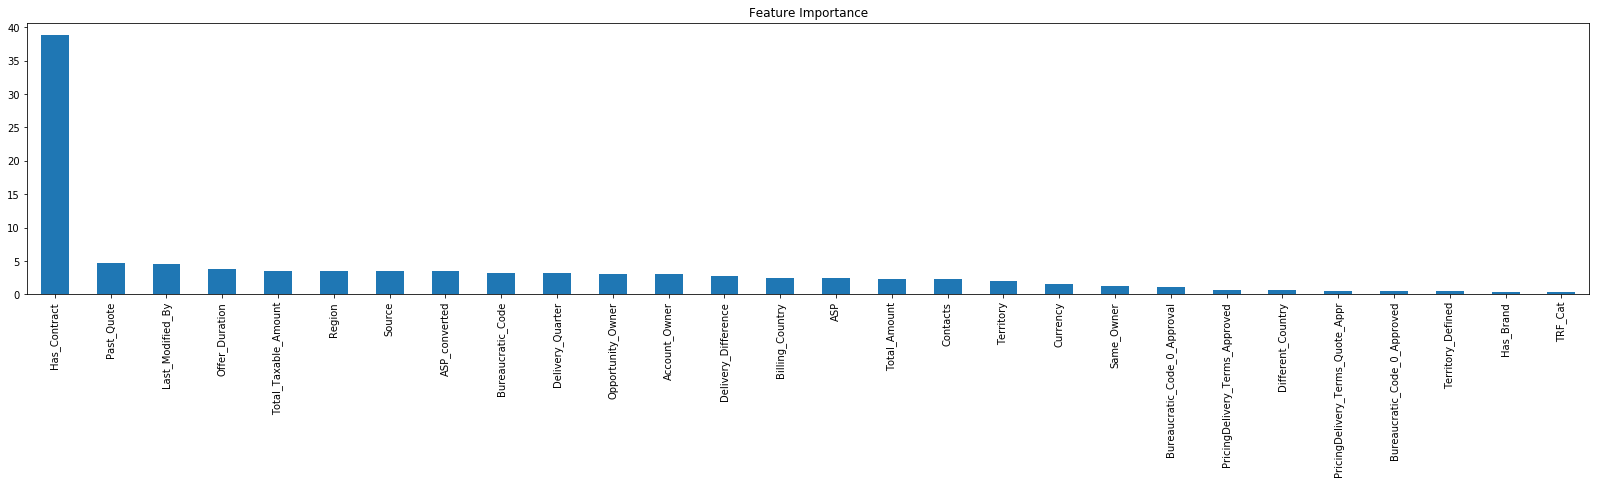

In [62]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [63]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [64]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Offer_Duration,Territory_Defined,Past_Quote,Prediction
7812,APAC,Australia,1,0,1,0,Bureaucratic_Code_5,None,Australia,4832,2252,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,130.0,True,131.0,0.991002
4773,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_13,Sri Lanka,2824,904,Person_Name_49,Person_Name_49,None,Person_Name_47,0.3600,0.36000,Q4,157172.40,157172.40,0,1,19.0,False,False,True,True,0.0,72.0,True,-27.0,0.998398
9800,APAC,Thailand,0,0,0,0,Bureaucratic_Code_4,Source_7,Thailand,6207,3436,Person_Name_54,Person_Name_54,None,Person_Name_47,0.4000,0.40000,Q4,120060.00,120060.00,0,1,0.0,False,False,True,False,0.0,57.0,True,70.0,0.969084
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,8.0,True,603.0,0.996500
9280,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,None,United States,5834,2880,Person_Name_64,Person_Name_64,None,Person_Name_47,0.4300,0.43000,Q4,30702.00,30702.00,0,1,0.0,False,False,True,True,0.0,4.0,True,183.0,0.769151
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,NaN,False,NaN,0.973892
15533,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,Source_7,Germany,9934,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.2300,0.26015,Q4,10666.25,10666.25,1,1,2.0,True,False,False,False,0.0,NaN,True,NaN,0.155214
7806,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,4826,2247,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,130.0,True,131.0,0.983038
8573,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,Source_7,United States,5368,2580,Person_Name_64,Person_Name_64,None,Person_Name_47,0.4300,0.43000,Q3,87290.00,87290.00,0,1,0.0,False,False,True,True,0.0,6.0,True,218.0,0.870593
7145,APAC,China (PRC),1,1,1,1,Bureaucratic_Code_4,None,China,4398,2178,Person_Name_65,Person_Name_19,None,Person_Name_47,0.2800,0.28000,Q2,103880.00,103880.00,0,1,15.0,False,False,True,True,0.0,46.0,True,223.0,0.973170


In [65]:
bad.Stage.value_counts()

0    81
1    17
Name: Stage, dtype: int64

In [66]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [67]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9936500328815553

In [68]:
prev = pd.read_csv("acceptable/submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9920427548380799

In [73]:
answer.to_csv("acceptable/submission_25.csv", header = False, index = False)

In [70]:
#p = prev.merge(answer, on = "Opportunity_ID")

In [71]:
#p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [72]:
#pp = p[["Opportunity_ID", "New_Prediction"]]
#pp.to_csv("submission_24.csv", header = False, index = False)